## Import Libraries

In [261]:
import cv2 
import pickle
import matplotlib.pyplot as plt
import numpy as np

### Resize Images function

In [262]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

## Generate Keypoint and Descriptors

### Prepare list of images

In [263]:

import os
imageList=[]
# for filename in os.listdir("data/images"):
for filename in os.listdir("data/person"):
    imageList.append(filename)



In [264]:
# We use grayscale images for generating keypoints
imagesBW = []
for imageName in imageList:
    # imagePath = "data/images/" + str(imageName)
    imagePath = "data/person/" + str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale

In [153]:
# # Gray-scale images improve speed

# imageBW = []
# for image in images:
#     imageBW.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

### Choose between opencv's SIFT and open source SIFT implementation<br>

In [265]:
# Using opencv's sift implementation here

sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

In [ ]:
# Using custom (rmislam/PythonSIFT) sift implementation
# Comparitively slower than opencv's implementation
# but source code is present in repo, hence easily modifiable

# import pysift

# def computeSIFT(image):
#     return pysift.computeKeypointsAndDescriptors(image)

### The following is the main function to generate the keypoints and descriptors<br>
When using SIFT, this takes a lot of time to compute.<br>
Thus, it is suggested, you store the values once computed<br>
(Code for storing is written below)

In [266]:
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + imageList[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Ending for image: " + imageList[i])


Starting for image: FO_001013_IFM+00_PM+00_EN_A0_D0_T0_BW_M0_R0_S0.tif
  Ending for image: FO_001013_IFM+00_PM+00_EN_A0_D0_T0_BW_M0_R0_S0.tif
Starting for image: FO_001013_IFM-45_PM+00_EN_A0_D0_T0_BW_M0_R0_S0.tif
  Ending for image: FO_001013_IFM-45_PM+00_EN_A0_D0_T0_BW_M0_R0_S0.tif
Starting for image: FY_000007_IFM+90_PM+00_EN_A0_D0_T0_BW_M0_R1_S0.tif
  Ending for image: FY_000007_IFM+90_PM+00_EN_A0_D0_T0_BW_M0_R1_S0.tif
Starting for image: FY_000007_IFM-45_PM+00_EN_A0_D0_T0_BW_M0_R1_S0.tif
  Ending for image: FY_000007_IFM-45_PM+00_EN_A0_D0_T0_BW_M0_R1_S0.tif
Starting for image: FY_000010_IFD+90_PM+00_EN_A0_D0_T0_BW_M0_R1_S0.tif
  Ending for image: FY_000010_IFD+90_PM+00_EN_A0_D0_T0_BW_M0_R1_S0.tif
Starting for image: FY_000010_IFD-90_PM+00_EN_A0_D0_T0_BW_M0_R1_S0.tif
  Ending for image: FY_000010_IFD-90_PM+00_EN_A0_D0_T0_BW_M0_R1_S0.tif
Starting for image: FY_000023_IFM+90_PM+00_EN_A0_D0_T0_BW_M0_R0_S0.tif
  Ending for image: FY_000023_IFM+90_PM+00_EN_A0_D0_T0_BW_M0_R0_S0.tif
Starti

### Store Keypoints and Descriptors for future use

In [267]:
for i,keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)    


In [268]:
for i,descriptor in enumerate(descriptors):
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)


## Prepare for fetching results

### Fetch Keypoints and Descriptors from stored files

In [269]:
def fetchKeypointFromFile(i):
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

In [270]:
def fetchDescriptorFromFile(i):
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

### Calculate Results for any pair

In [271]:
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(len(matches),len(keypoint1),len(keypoint2),len(descriptor1),len(descriptor2))
    print("得分(10就算高)",score)
    plt.imshow(plot),plt.show()

In [281]:
def getPlotFor(i,j,keypoint1,keypoint2,matches):
    # image1 = imageResizeTest(cv2.imread("data/images/" + imageList[i]))
    # image2 = imageResizeTest(cv2.imread("data/images/" + imageList[j]))
    image1 = imageResizeTest(cv2.imread("data/person/" + imageList[i]))
    image2 = imageResizeTest(cv2.imread("data/person/" + imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

### Basic Scoring metric
A score greater than 10 means very good

In [273]:
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

### knn matching

In [274]:
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

In [275]:
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        [255,255,255],
        flags=2
    )
    return matchPlot

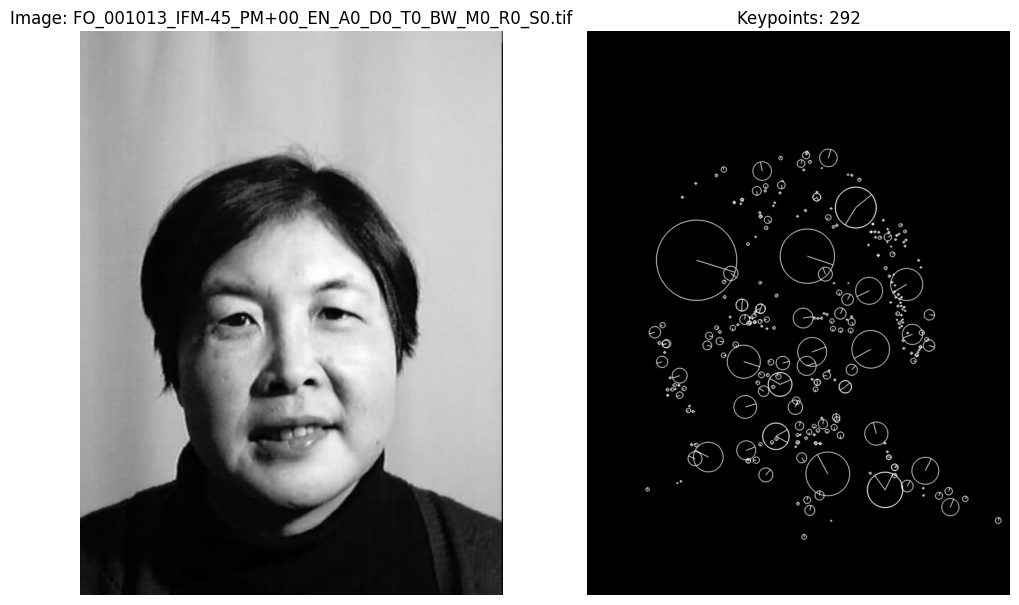

In [278]:
def displayKeypoints(image_index):
    """显示指定图像的关键点"""
    # 加载图像和关键点
    image_name = imageList[image_index]
    # image = imageResizeTest(cv2.imread(f"data/images/{image_name}"))
    image = imageResizeTest(cv2.imread(f"data/person/{image_name}"))
    back_ground = np.zeros((image.shape[0],image.shape[1],3),dtype=np.uint8)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    keypoints = fetchKeypointFromFile(image_index)
    
    # 绘制关键点
    img_with_keypoints = cv2.drawKeypoints(
        back_ground, 
        keypoints, 
        None, 
        color=(255, 255, 255), 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    # 显示图像
    plt.figure(figsize=(12, 10))
    axis1 = plt.subplot(1, 2, 1)
    axis1.imshow(image)
    axis1.axis('off')
    axis1.set_title(f"Image: {image_name}")
    axis2 = plt.subplot(1, 2, 2)
    axis2.imshow(img_with_keypoints)
    axis2.axis('off')
    axis2.set_title(f"Keypoints: {len(keypoints)}")
    
    plt.show()
    

# 使用示例：显示第9张图像 (ironman2.jpg) 的关键点
displayKeypoints(1)

## Fetch Results

### Sample Results

5 298 197 298 197
得分(10就算高) 2.5380710659898478


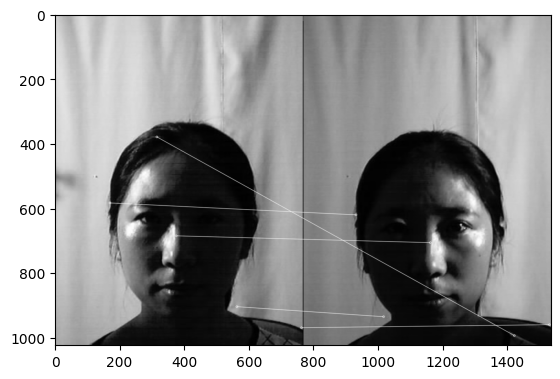

In [286]:
calculateResultsFor(6,7)
